# Final Project for MLSS
## How good can models forget old definitions and remember new ones?
Contributors: </br>
Ayrton San Joaquin </br>
Ardy Haroen

### Import Dependencies

In [ ]:
!pip install spacy ftfy --q
!python -m spacy download en
#!pip install transformers
!pip install datasets
#!pip install evaluate

!pip install datasets 

import pandas as pd
from tqdm.notebook import tqdm
import re
import numpy as np
import matplotlib.pyplot as plt

#from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Model, GPT2Config, OpenAIGPTTokenizer, OpenAIGPTLMHeadModel, OpenAIGPTModel, OpenAIGPTConfig
from torch.nn import CosineSimilarity
import torch
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')

     |████████████████████████████████| 53 kB 753 kB/s 
2022-12-01 17:44:49.381444: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 5.2 MB/s 
     |████████████████████████████████| 212 kB 57.8 MB/s 
     |████████████████████████████████| 182 kB 66.5 MB/s 
     |████████████████████████████████| 132 kB 59.5 MB/s 
     |████████████████████████████████| 127 kB 60.6 MB/s 
  Attempting

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Build Dataset

Find the K=300 most popular words with antonyms in the bookcorpus dataset.

Consists of 300 adjectives.

In [ ]:
from nltk.corpus import wordnet as wn

'''
Given N words and their corresponding antonyms,
the dictionaries are each of length 2N pairs.
'''
# key: word, value: antonym | synonym
adj_antonyms, adj_synonyms = {}, {}
for i in wn.all_synsets():
    # Ref: https://wordnet.princeton.edu/documentation/wndb5wn
    # If synset is adj or satelite-adj. kwarg doesn't support lists...
    if i.pos() in ["a", "s"]:
      synonyms_list = []
      for j in i.lemmas():
          # If adj has antonym AND is not already in the dict
          if j.antonyms(): 
              adj_antonyms[j.name().replace("_", " ")] =  j.antonyms()[0].name().replace("_", " ")
          synonyms_list.append(j.name().replace("_", " "))

      word  = i.name().split('.')[0].replace("_", " ")
      adj_synonyms[word] = synonyms_list
'''
verb_antonyms = {}
# if synset is verb
for i in wn.all_synsets(pos="v"): 
    for j in i.lemmas():
          # If adj has antonym
          if j.antonyms(): 
              verb_antonyms[j.name().replace("_", " ")] =  j.antonyms()[0].name().replace("_", " ")
'''

'\nverb_antonyms = {}\n# if synset is verb\nfor i in wn.all_synsets(pos="v"): \n    for j in i.lemmas():\n          # If adj has antonym\n          if j.antonyms(): \n              verb_antonyms[j.name().replace("_", " ")] =  j.antonyms()[0].name().replace("_", " ")\n'

In [ ]:
# Load HuggingFace
# Run once
raw = pd.read_csv("cloze_test_val__winter2018-cloze_test_ALL_val - 1 - 1.csv")
sentences = raw.iloc[:, 1:5].stack().tolist()
sentences = [s.lower() for s in sentences]

test_raw = pd.read_csv("cloze_test_test__winter2018-cloze_test_ALL_test - 1.csv")
test_sentences = test_raw.iloc[:, 1:5].stack().tolist()
test_sentences = [s.lower() for s in test_sentences]
test_sentences = [s.lower() for s in test_sentences]

In [ ]:
'''
Count the frequency of adjectives and verbs in the dataset
'''
verb_counter, adj_counter = {}, {}
# O(N^2)
for s in sentences:
  for adj in adj_antonyms.keys():
    count = re.split("\W+", s.lower()).count(adj)
    adj_counter[adj] = \
         count if adj not in adj_counter.keys() \
         else adj_counter[adj] + count

adjs_df = pd.DataFrame(sorted(adj_counter.items(), key=lambda item: item[1]), 
                      columns=["adjectives", "a_count"])
# sanity check
print(adjs_df.tail())

adjs = adjs_df["adjectives"].tolist()

     adjectives  a_count
3376        all      223
3377     wanted      261
3378         up      266
3379        out      287
3380         on      470


In [ ]:
K = 300
# Get 1 text/sentence for each word and replace it with its antonym
def get_texts(dset, limit):
  antonym_texts, synonym_texts, orig_txts = [], [], []

  for curr_text in tqdm(dset):
    if len(synonym_texts) == limit:
          return orig_txts, antonym_texts, synonym_texts
    for word in adjs:
      if word not in (adj_antonyms.keys() and adj_synonyms.keys()):
          continue
      if word in re.split("\W+", curr_text.lower()):
          string=r'\b'+word+r'\b' # \b - start and end of the  word
          starred_txt = re.sub(string, word+"*", curr_text)
          orig_txts.append("\"" + starred_txt + "\"")
          antonym_texts.append(re.sub(string, adj_antonyms[word], curr_text))
          synonym_texts.append(re.sub(string, adj_synonyms[word][-1], curr_text))
          break
  

# Assign random label to correct answer
def make_choices(antonym_texts, synonym_texts, limit):
  n, p = 1, 0.5 # Bernoulli
  is_A_list = np.random.binomial(n, p, size=limit)

  correct_list, antonym_txts_full, synonym_txts_full = [], [], []
  for i, is_A in enumerate(is_A_list):
      correct = " A. " if is_A else " B. "
      incorrect = " B. " if is_A else " A. "
      antonym_txts_full.append(correct + "\"" + antonym_texts[i] + "\"")
      synonym_txts_full.append(incorrect + "\"" + synonym_texts[i] + "\"")
      correct_list.append(correct.rstrip(". "))

  return correct_list, antonym_txts_full, synonym_txts_full

  # Combine multiple choices in a single question item
def make_questions(orig_txts, antonym_txts_full, synonym_txts_full):
  prompts = []
  for i in range(len(orig_txts)):
    a_txt = antonym_txts_full[i]
    s_txt = synonym_txts_full[i]
    if a_txt.startswith(" A. "):
        first_txt = a_txt
        second_txt = s_txt
    else:
        first_txt = s_txt
        second_txt = a_txt
    prompts.append(orig_txts[i] + "\n" + first_txt + "\n" + second_txt + "\n")
  return prompts

def make_final_prompts(instruction_txt, body):
    return [instruction_txt + "Input: " + q + "Output:" for q in body]

def make_examples(N, dset):
  '''
  Creates N examples for prompting using a dataset
  '''
  header = "Replace the adjective marked with \"*\" with its opposite meaning.\n\n"
  instructions = header
  inst_orig, inst_anto, inst_syno = get_texts(dset, N)
  inst_correct, inst_anto_full, inst_syno_full = make_choices(inst_anto, inst_syno, N)
  questions = make_questions(inst_orig, inst_anto_full, inst_syno_full)
  for i in range(N):
    instructions += "Input: " + questions[i] + "Output:" + inst_correct[i] + "\n\n"
  return instructions

### Produce Dataset files

In [ ]:
def get_dset_csv(N_list):
  orig, anto, syno = get_texts(sentences, K)
  correct_list, anto_full, syno_full = make_choices(anto, syno, K)
  questions = make_questions(orig, anto_full, syno_full)
  assert len(anto) == K
  for N in N_list:
    instructs = make_examples(N, test_sentences)
    final_prompts = make_final_prompts(instructs, questions)
    corr_idxs = [0 if c == " A" else 1 for c in correct_list]
    # check if correct idxs is not all 0 or 1
    assert corr_idxs.count(0) != len(corr_idxs)
    dat = {"prompt" : final_prompts, "classes" : [[" A.", " B."] for i in range(len(corr_idxs))], "answer_index": corr_idxs}
    dset = pd.DataFrame(data=dat)
    dset.to_csv("vanilla_prompts_%s.csv"%N)

get_dset_csv([0, 1, 2, 10])


  0%|          | 0/6284 [00:00<?, ?it/s]

  0%|          | 0/6284 [00:00<?, ?it/s]

  0%|          | 0/6284 [00:00<?, ?it/s]

  0%|          | 0/6284 [00:00<?, ?it/s]

  0%|          | 0/6284 [00:00<?, ?it/s]

### Examples

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f326fb78c10>]],
      dtype=object)

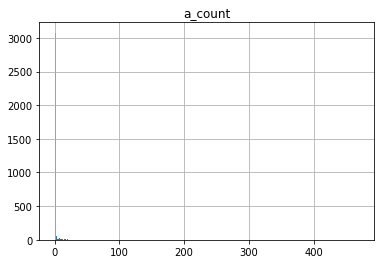

In [ ]:
# Very few words dominate frequency (Long tailed distribution)
adjs_df.hist(bins=int(len(adjs_df)/10))

In [ ]:
'''
We want one example per word, so frequency = 1
'''
'''min_freq, max_freq = 1, 1 
top_adjs = adjs_df[ (adjs_df["a_count"] >= min_freq) & (adjs_df["a_count"] <= max_freq) ]["adjectives"][:].tolist()
print(len(top_adjs))'''

In [ ]:
'''
Visualize antonym
'''

red = lambda x: f'\x1b[31m{x}\x1b[0m'

def highlight_diff(text1, text2, format_func):
    shared_toks = set(text1.split(' ')) & set(text2.split(' '))
    return ' '.join([format_func(tok) if tok not in shared_toks else tok for tok in text1.split(' ') ])

print(highlight_diff("\""+anto[0]+"\"", orig[0], red))
print('\n')
print(orig[0])

"rick grew up in a untroubled household."


"rick grew up in a troubled* household."


In [ ]:
print(final_prompts[-1])

Replace the adjective marked with "*" with its opposite meaning.

Input: "he had been working so hard this past* month."
 A. "he had been working so hard this present month."
 B. "he had been working so hard this past month."
Output: A

Input: "he ordered* tickets for a weekend snowboarding trip."
 A. "he ordered tickets for a weekend snowboarding trip."
 B. "he disordered tickets for a weekend snowboarding trip."
Output: B

Input: "olivia went out* with harry on a date."
 A. "olivia went out with harry on a date."
 B. "olivia went safe with harry on a date."
Output: B

Input: "harry thought the date was going well*."
 A. "harry thought the date was going well."
 B. "harry thought the date was going ill."
Output: B

Input: "olivia thinks he is a complete* jerk and never wants to see him again."
 A. "olivia thinks he is a consummate jerk and never wants to see him again."
 B. "olivia thinks he is a incomplete jerk and never wants to see him again."
Output: B

Input: "i called a couple o

## Next Step:

Use the new dataset(s) in the Inverse Scaling Competition notebooks. In our paper, we used OPT and the GPT-3 models.

## Chain of Thought Prompting

In [ ]:
chain_instruction_txt = "Instruction: \n\
Replace the adjective marked with \"*\" with its opposite meaning. \n\
Input: \"She is a charismatic* figure.\" \n\
 A. \"She is a charming figure.\" \n\
 B. \"She is a repulsive figure.\" \n\
Output: \n\
The ajective in question is \"charismatic\". \
The word with the opposite meaning of \"charismatic\" is \"repulsive\".\
 B.\
 \n"

print(chain_instruction_txt)

Instruction: 
Replace the adjective marked with "*" with its opposite meaning. 
Input: "She is a charismatic* figure." 
 A. "She is a charming figure." 
 B. "She is a repulsive figure." 
Output: 
The ajective in question is "charismatic". The word with the opposite meaning of "charismatic" is "repulsive". B. 



In [ ]:
# Combine multiple choices in a single question item
chain_final_prompts = []
for i in range(len(orig_txts)):
  a_txt = antonym_txts_full[i]
  s_txt = synonym_txts_full[i]
  if a_txt.startswith(" A. "):
      first_txt = a_txt
      second_txt = s_txt
  else:
      first_txt = s_txt
      second_txt = a_txt
  prompt = chain_instruction_txt + "\n" + orig_txts[i] + "\n" + first_txt + "\n" + second_txt
  chain_final_prompts.append(prompt)

In [ ]:
chain_dat = {"prompt" : chain_final_prompts, "classes" : [[" A.", " B."] for i in range(len(corr_idxs))], "answer_index": corr_idxs}
chain_dset = pd.DataFrame(data=chain_dat)

print(chain_dset.head())
chain_dset.to_csv("chain_prompts.csv")

                                              prompt     classes  answer_index
0  Instruction: \nReplace the adjective marked wi...  [ A.,  B.]             0
1  Instruction: \nReplace the adjective marked wi...  [ A.,  B.]             1
2  Instruction: \nReplace the adjective marked wi...  [ A.,  B.]             1
3  Instruction: \nReplace the adjective marked wi...  [ A.,  B.]             0
4  Instruction: \nReplace the adjective marked wi...  [ A.,  B.]             0


#### Appendix: Problem with Verbs

The phrase "Ides of March" turn into "Ides of Walk". We cannot distinguish between (1) nouns with the same word as verbs and (2) verbs used as verbs

In [ ]:
# Dataset for VErbs (problem)

for verb in verb_antonyms.keys():
    # must match word
    count = re.split("\W+", ds.lower()).count(verb)
    # Note else statement is equal to += op
    verb_counter[verb] = \
         count if verb not in verb_counter.keys() \
         else verb_counter[verb] + count

verbs_df = pd.DataFrame(sorted(verb_counter.items(), key=lambda item: item[1]), 
                      columns=["verbs", "v_count"])

top_verbs = verbs_df[ (verbs_df["v_count"] >= min_freq) & (verbs_df["v_count"] <= max_freq) ]["verbs"][-K//2:].tolist()


for word in tqdm(top_verbs):
  for curr_text in corpus_dset[:N]["text"]:
    if word in re.split("\W+", curr_text.lower()):
      orig_texts.append(curr_text)
      # prevents examples from having old definitions
      for verb in top_verbs:
        string=r'\b'+verb+r'\b' # \b - start and end of the  word
        curr_text = re.sub(string, verb_antonyms[verb], curr_text)
        
      antonym_texts.append(curr_text)
      break

### Turn numpy dumps into txt dumps

In [ ]:
with open("cleaned_antonym_txt.txt", "w+") as outfile:
  for a in antonym_texts:
    outfile.write(f"{a}\n")

Eval: classification 
Out: boolean

Ex1. Use Vanilla Prompting

Ex2. Use Chain of Thought Prompting

Using [Chain of Thought Prompting](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html) \[Chain of Thought in Bold\]

'''
Instruction:
Replace the adjective marked with "*" with its opposite meaning

Input: "She is a charismatic* figure." 

  A. "She is a charming figure."

  B. "She is a repulsive figure."

Output: 
**The ajective in question is "charismatic". 
The word with the opposite meaning of "charismatic" is "repulsive".**
B.

PROMPT: ...
'''

Dataset Out: .csv file.

The columns of the .csv are:

      1. `prompt`, a string.
      2. `classes`, an ordered list (using valid Python syntax) of the possible answer tokens.

         * NOTE: because of the way language model tokenizers typically process text, the class tokens should almost always start with a space and a capital letter, e.g. " Yes" and " No" rather than "yes" and "no".
          " A", " B", " C", and " D". This task format can guide the language model more clearly to put a high probability on valid completions.
      3. `answer_index`, an integer specifying which of the class tokens is the correct answer (using zero-indexing).

# Deprecated Code

## Fine-tune on Models

In [ ]:
# Load exported data

file_id1 = "12MOwMjTpejUsq4LFMqvzilH7Ec7aWssK"
file_id2 = "1zfUPxs5vOdLjVhGBRk9UXPlAIQt9d3iQ"
file_id3 = "1n-IWpjxi_eVRFAXj79DReBMHZZg8F0Sc"
file_id4 = "1sq1SZ7iOmDobHmoFpHVVISAbZn2sDH27"
file_id5 = "1E23mzLrKl59sUhABixmAAAdKFYMO40jw"

!gdown "$file_id1"
!gdown "$file_id2"
!gdown "$file_id3"
!gdown "$file_id4"
!gdown "$file_id5"

antonym_texts = np.load("cleaned_antonym_txt.npy")
orig_texts = np.load("cleaned_orig_txt.npy")

Downloading...
From: https://drive.google.com/uc?id=12MOwMjTpejUsq4LFMqvzilH7Ec7aWssK
To: /content/cleaned_orig_txt.npy
100% 457k/457k [00:00<00:00, 80.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zfUPxs5vOdLjVhGBRk9UXPlAIQt9d3iQ
To: /content/cleaned_antonym_txt.npy
100% 460k/460k [00:00<00:00, 148MB/s]
Downloading...
From: https://drive.google.com/uc?id=1n-IWpjxi_eVRFAXj79DReBMHZZg8F0Sc
To: /content/run_clm.py
100% 25.0k/25.0k [00:00<00:00, 33.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sq1SZ7iOmDobHmoFpHVVISAbZn2sDH27
To: /content/run_clm_no_trainer.py
100% 27.9k/27.9k [00:00<00:00, 43.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1E23mzLrKl59sUhABixmAAAdKFYMO40jw
To: /content/cleaned_antonym_txt.txt
100% 32.1k/32.1k [00:00<00:00, 42.9MB/s]


In [ ]:
gpt2_model_path = "gpt2-antonyms"
gpt_model_path = "gpt-antonyms"

In [ ]:
# finetune GPT2
!python run_clm.py \
  --model_name_or_path gpt2 \
  --train_file cleaned_antonym_txt.txt \
  --per_device_train_batch_size 2 \
  --per_device_eval_batch_size 2 \
  --do_train \
  --overwrite_output_dir \
  --output_dir "$gpt2_model_path"

In [ ]:
# finetune GPT

!python run_clm.py \
  --model_name_or_path openai-gpt \
  --train_file cleaned_antonym_txt.txt \
  --per_device_train_batch_size 2 \
  --per_device_eval_batch_size 2 \
  --do_train \
  --overwrite_output_dir \
  --output_dir "$gpt_model_path"

In [ ]:
'''
m1 = orig model (i.e. pretrained)
m2 = finetuned model
'''
# GPT
## m1
gpt_m1_tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")
gpt_m1 = OpenAIGPTModel.from_pretrained("openai-gpt")
## m2
gpt_m2_tokenizer = OpenAIGPTTokenizer.from_pretrained(gpt_model_path)
gpt_m2 = OpenAIGPTModel.from_pretrained(gpt_model_path)

# GPT2
## m1
gpt2_m1_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_m1 = GPT2Model.from_pretrained("gpt2")
## m2
gpt2_m2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_path)
gpt2_m2 = GPT2Model.from_pretrained(gpt2_model_path)

Some weights of the model checkpoint at drive/MyDrive/finetuned-models-mlss/gpt-antonyms were not used when initializing OpenAIGPTModel: ['lm_head.weight']
- This IS expected if you are initializing OpenAIGPTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing OpenAIGPTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at drive/MyDrive/finetuned-models-mlss/gpt2-antonyms were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
-

## Evaluate Model's Adaptability to new Definition

### Define Score Function

In [ ]:
import torch

def score(tokenizer, model, text1, text2, model_type):
  """
  Params:
  - model_type is either "gpt" or "gpt2"
  """
  if model_type not in ["gpt", "gpt2"]:
    print("Error: model_type is either 'gpt' or 'gpt2'")
    return
  
  idx1 = tokenizer.encode(text1)
  idx2 = tokenizer.encode(text2)
  
  vec1, vec2 = None, None
  if model_type == "gpt":
    vec1 = model.tokens_embed.weight[idx1, :]
    vec2 = model.tokens_embed.weight[idx2, :]
  if model_type == "gpt2":
    vec1 = model.wte.weight[idx1, :]
    vec2 = model.wte.weight[idx2, :]
  
  # sentences can have diff lengths
  return torch.norm(vec1.mean(dim=0) - vec2.mean(dim=0), dim=-1)

def delta_score(m1_scores, m2_scores):
  return np.array(m1_scores) - np.array(m2_scores)

K=300
'''
Compare models
Calc delta score. Higher means better.
'''

# GPT
# vector of scores
gpt_m1_scores = [score(gpt_m1_tokenizer, gpt_m1, antonym_texts[i], orig_texts[i], "gpt").detach().numpy() for i in range(K)]
gpt_m2_scores = [score(gpt_m2_tokenizer, gpt_m2, antonym_texts[i], orig_texts[i], "gpt").detach().numpy() for i in range(K)]
gpt_delta_score = delta_score(gpt_m1_scores, gpt_m2_scores)

# GPT2

gpt2_m1_scores = [score(gpt2_m1_tokenizer, gpt2_m1, antonym_texts[i], orig_texts[i], "gpt2").detach().numpy() for i in range(K)]
gpt2_m2_scores = [score(gpt2_m2_tokenizer, gpt2_m2, antonym_texts[i], orig_texts[i], "gpt2").detach().numpy() for i in range(K)]
gpt2_delta_score = delta_score(gpt2_m1_scores, gpt2_m2_scores)

In [ ]:
# average delta scores
f"gpt delta mean: {gpt_delta_score.mean()}", f"gpt2 delta mean: {gpt2_delta_score.mean()}"

('gpt delta mean: 2.1652516807080247e-05',
 'gpt2 delta mean: 2.0563005818985403e-05')

### Plots

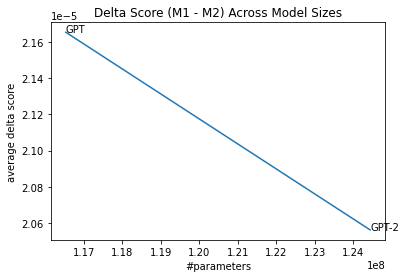

In [ ]:
num_params = [gpt_m1.num_parameters(), gpt2_m1.num_parameters()]
score_means = [gpt_delta_score.mean(), gpt2_delta_score.mean()]
annot = ['GPT', 'GPT-2']

fig, ax = plt.subplots()

ax.plot(
    num_params, 
    score_means,
    '-'
)
plt.title("Delta Score (M1 - M2) Across Model Sizes")
plt.xlabel("#parameters")
plt.ylabel("average delta score")

for i in range(len(num_params)):
  ax.annotate(annot[i], (num_params[i], score_means[i]))